In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *          

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
sfh_all = pd.read_csv('data/sfhousing.csv', on_bad_lines='skip')
sfh = sfh_all.query('year == 2004')
dogs = pd.read_csv('data/akc.csv').dropna()

(ch:viz_scale)=
# Choosing Scale to Reveal Structure


In {numref}`Chapter %s <ch:eda>`, we explored prices for houses sold in the San Francisico Bay Area between 2003 and 2009. Let's revisit that example and take a look at a histogram of sale prices:

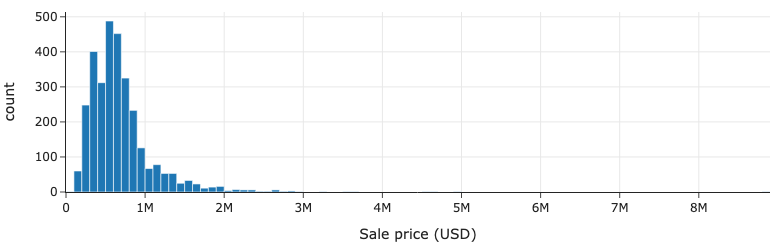

In [4]:
px.histogram(sfh, x='price', nbins=100,
             labels={'price':"Sale price (USD)"}, width=350, height=250)

While this plot accurately displays the data,
most of the visible bins are crammed into the left side of the plot.
This makes it hard to understand the distribution of prices.

Through data visualization, we want to reveal important features of the data,
like the shape of a distribution and the relationship between two or more features. 
As this example shows, after we produce an initial plot, there are still other aspects we need to consider.
In this section, we cover *principles of scale* that help us decide how to
adjust the axis limits, place tick marks, and apply transformations. 
We begin by examining when and how we might adjust a plot to reduce empty space; in other words, we try to fill the data region of our plot with data.

## Filling the Data Region

As we can see from the histogram of sale prices, it's hard to read
a distribution when
most of the data appear in a small portion of the plotting region.
When this happens, important features of the data, like
multiple modes and skewness can be obscured.
A similar issue happens for scatter plots. 
When all the points are bunched together in the corner of a scatter plot, it's hard to see the shape of the distribution and therefore glean any insights the shape would impart.

This issue can crop up when there are a few unusually large observations.
In order to get a better view of the main portion
of the data, we can drop those observations from the plot by adjusting the
x- or y-axis limits, or we can remove the outlier values from the data before plotting.
In either case, we mention this exclusion in
the caption or on the plot itself.

Let's use this idea to improve the histogram of sale prices.
In the side-by-side plots that follow, we clip the data by changing the limits of the x-axis. 
On the left, we've excluded houses that cost over $2 million. 
The shape of the distribution for the bulk of the houses is much clearer in this plot.
For instance, we can more easily observe the skewness and a smaller secondary mode.
On the right, we separately show detail in the long right tail of the distribution:

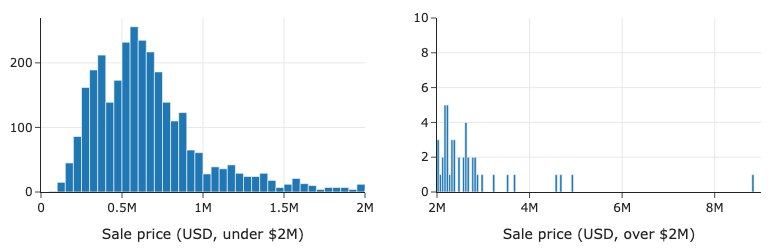

In [5]:
right_hist = px.histogram(sfh, x='price')
left_hist = px.histogram(sfh, x='price')
# We wrote the left_right function as a shorthand for plotly's make_subplots
fig = left_right(left_hist, right_hist, height=250)
fig.update_xaxes(range=[0, 2e6], title_text="Sale price (USD, under $2M)", row=1, col=1)
fig.update_xaxes(range=[2e6, 9e6], title_text="Sale price (USD, over $2M)", row=1, col=2)
fig.update_yaxes(range=[0, 10], row=1, col=2)
fig

Notice that the x-axis in the left plot includes 0, but the x-axis in the right plot begins at $2M. We consider when to include or exclude 0 on an axis next. 

## Including Zero

We often don't need to include 0 on an axis, especially if including it makes it difficult to fill the data region. For example, let's make a scatter plot of average longevity plotted against average height for dog breeds. (This dataset was first introduced in {numref}`Chapter %s <ch:eda>`; it includes several features for 172 breeds.)   

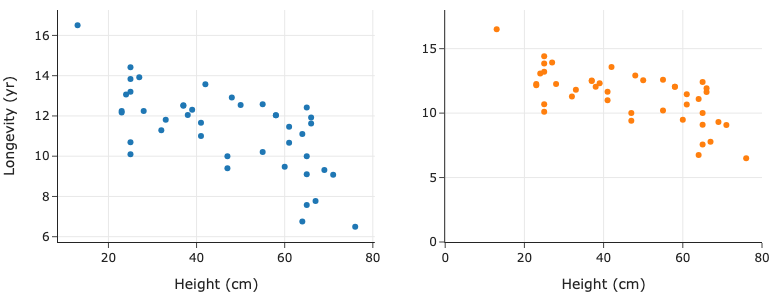

In [6]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=dogs['height'], y=dogs['longevity'], mode="markers"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=dogs['height'], y=dogs['longevity'], mode="markers"),
    row=1, col=2
)

fig.update_xaxes(range=[0, 80], row=1, col=2, title_text="Height (cm)")
fig.update_yaxes(range=[0, 18], row=1, col=2)
fig.update_xaxes(row=1, col=1, title_text="Height (cm)")
fig.update_yaxes(row=1, col=1, title_text="Longevity (yr)")

fig.update_layout(height=300, width=600, showlegend=False)
fig.show()

The x-axis of the plot on the left starts at 10 cm since all dogs are at least that tall, and similarly, the y-axis begins at 6 years. The scatter plot on the right includes 0 on both axes. This pushes the data up to the top of the data region and leaves empty space that doesn't help us see the linear relationship.  

There are some cases where we usually want to include 0.
For bar charts, including 0 is important so that the heights of the bars directly relate to the data values.
As an example, we've created two bar charts that compare the longevity of dog breeds. 
The left plot includes 0, but the right plot doesn't: 

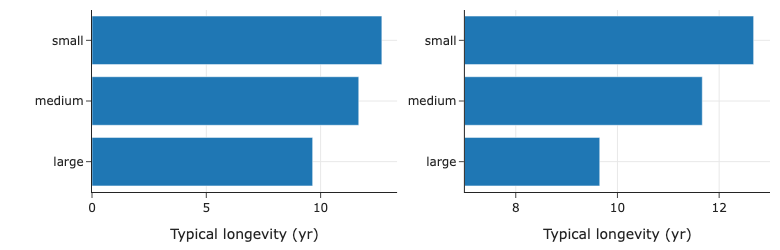

In [7]:
dogs_lon = dogs.groupby('size')['longevity'].mean().reset_index()
sml = {"size": ['small', 'medium', 'large']}

left = px.bar(dogs_lon, x='longevity', y='size', category_orders=sml)
right = px.bar(dogs_lon, x='longevity', y='size', category_orders=sml)
fig = left_right(left, right, height=250)
fig.update_xaxes(range=[7, 13], row=1, col=2)
fig.update_xaxes(title_text='Typical longevity (yr)')
fig.update_layout(yaxis_title="")
fig.show()

It's easy to incorrectly conclude from the right
plot that small breeds live twice as long as large breeds.

We also typically want to include 0 when working with proportions, since proportions range from 0 to 1.
The following plot shows the proportion of breeds in each type:

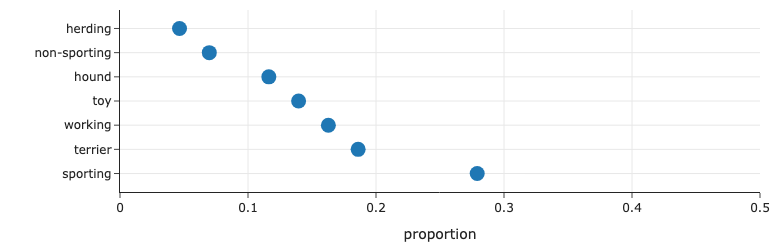

In [8]:
size_props = ((dogs['group'].value_counts() / len(dogs))
              .reset_index()
              .rename(columns={'count': 'proportion'}))

fig = px.scatter(size_props, x='proportion', y='group',
                 width=350, height=250)
fig.update_traces(marker_size=15)
fig.update_xaxes(range=[0, 0.5])
fig.update_yaxes(title_text='')
fig.show()

In both the bar and dot plots, including 0 makes it easier for you to accurately compare the relative sizes of the categories.  

Earlier, when we adjusted axes, we essentially dropped data from our plotting region. While this is a useful strategy when a handful of observations are unusually large (or small), it is less effective with skewed distributions. In this situation, we often need to transform the data to gain a better view of its shape.  

## Revealing Shape Through Transformations

Another common way to adjust scale is to transform the data or the plot's axes. 
We use transformations for skewed data so that it is easier to inspect the distribution.
And when the transformation produces a symmetric distribution, the symmetry carries with it useful properties for modeling (see {numref}`Chapter %s <ch:linear>`).

There are multiple ways to transform data, but the log transformation tends to be especially useful.
For instance, in the following charts we reproduced two histograms of San Francisco house sale prices.
The left histogram is the original data.
On the right, we took the log (base 10) of the prices before plotting:

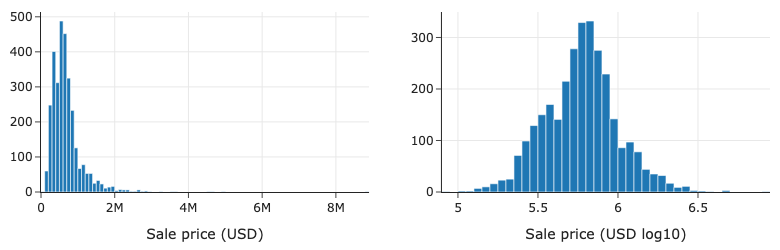

In [9]:
sfl = sfh.assign(log_price=np.log10(sfh['price']))

orig = px.histogram(sfl, x='price', nbins=100,
                    width=350, height=250)
logged = px.histogram(sfl, x='log_price', nbins=50, 
                      width=350, height=250)

fig = left_right(orig, logged)
fig.update_xaxes(title_text='Sale price (USD)', row=1, col=1)
fig.update_xaxes(title_text='Sale price (USD log10)', row=1, col=2)
fig.show()

The log transformation makes the distribution of prices more symmetric.
Now we can more easily see important features of the distribution, like
the mode at around $10^{5.85}$, which is about 700,000, and the secondary mode
near $10^{5.55}$ or 350,000.

The downside of using the log transform is that the actual values aren't
as intuitive---in this example, we needed to convert the values back to dollars to understand the sale price. Therefore, we often favor transforming the axis to a log scale, rather than the data. This way, we can see the original values on the axis:

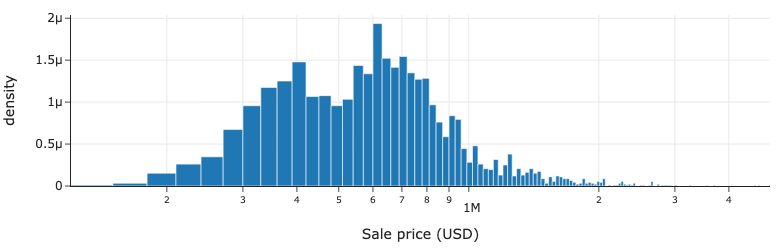

In [10]:
fig = px.histogram(sfh, x='price',
                   log_x=True,
                   histnorm='probability density',
                   labels={"price": "Sale price (USD)"},
                   width=350, height=250)

fig.update_traces(xbins_size=30_000)
fig.update_yaxes(title="density")
fig.show()

This histogram with its log-scaled x-axis essentially shows the same shape as the histogram of the transformed data.
But since the axis is displayed in the original units, we can directly
read off the location of the modes in dollars. Note that the bins get narrower to the right because the bin widths are equal on the USD scale but plotted on the log USD scale. Also note that $\mu$ on the y-axis is $10^{-6}$. 

The log transform can also reveal shape in scatter plots.
Here, we've plotted building size on the x-axis and
lot size on the y-axis.
It's hard to see the shape in this plot since many of the points are crammed
along the bottom of the data region:

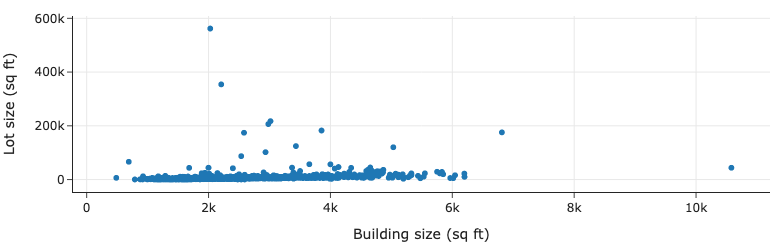

In [11]:
px.scatter(sfh, x='bsqft', y='lsqft', 
           labels={"bsqft": "Building size (sq ft)",
                    "lsqft": "Lot size (sq ft)"},
           width=350, height=250)

However, when we use a log scale for both the x- and y-axes, the shape of the relationship is much easier to see:

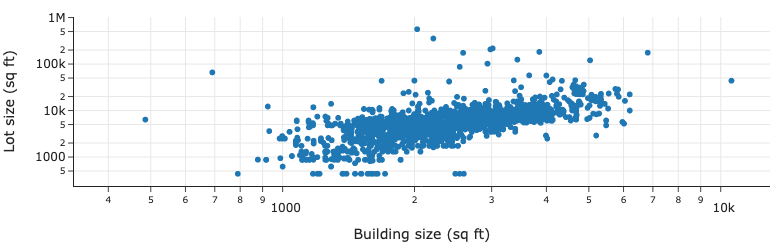

In [12]:
px.scatter(sfh, x='bsqft', y='lsqft',
           log_x=True, log_y=True, 
           labels={"bsqft": "Building size (sq ft)",
                   "lsqft": "Lot size (sq ft)"},
           width=350, height=250)

With the transformed axes, we can see that the lot size increases roughly linearly with building size (on the log scale). The log transformation pulls large values---values that are orders of magnitude larger than others---in toward the center. This transformation can help fill the data region and uncover hidden structure, as we saw for both the distribution of house price and the relationship between house size and lot size. 

In addition to setting the limits of an axis and transforming an axis, we also want to consider the aspect ratio of the plot---the length compared to the width. Adjusting the aspect ratio is called *banking*, and in the next section, we show how banking can help reveal relationships between features.  

## Banking to Decipher Relationships

With scatterplots, we try to choose scales so that the relationship between the two features roughly follows a
45-degree line. This scaling is called _banking to 45 degrees_.
It makes it easier to see shape and trends because our eyes can more easily pick up deviations from a line this way.
As an example of this, we've reproduced the plot that shows longevity of dog breeds against height:

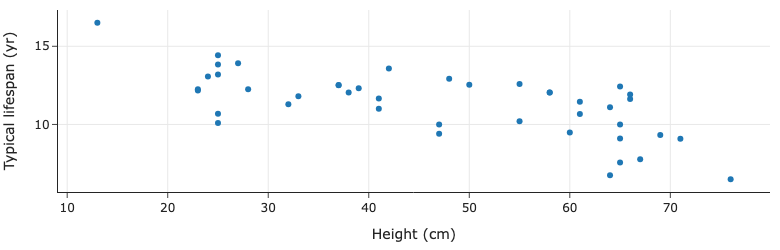

In [13]:
px.scatter(dogs, x='height', y='longevity', width=300, height=250,
           labels={"height": "Height (cm)",
                   "longevity": "Typical lifespan (yr)"})

The scatter plot has been banked to 45 degrees, and we can more easily
see how the data roughly follow a line and where they deviate a bit at the extremes.

While banking to 45 degrees helps us see whether or not the data follow a linear relationship, when there is clear curvature it can be hard to figure out the form of the relationship. When this happens, we try transformations that will get the data to fall along a straight line (see, for example, {numref}`Figure %s <example-transforms>`).
The log transformation can be useful in uncovering the general form of curvilinear relationships.

## Revealing Relationships Through Straightening

We often use scatter plots to look at the relationship between two features.
For instance, here we've plotted height against weight
for the dog breeds:

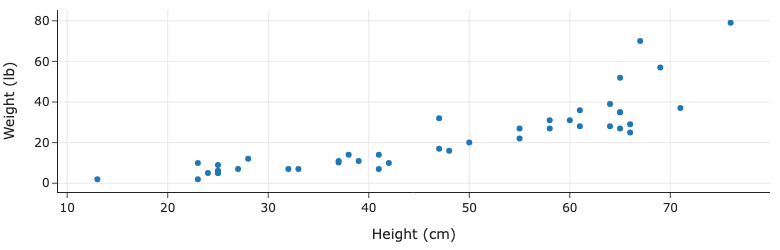

In [14]:
px.scatter(dogs, x='height', y='weight', width=350, height=250,
           labels={"height": "Height (cm)", "weight": "Weight (lb)"})

We see that taller dogs weigh more, but this relationship isn't linear.

When it looks like two variables have a nonlinear relationship, it's useful
to try applying a log scale to the x-axis, y-axis, or both.
Let's look for a linear relationship in the scatter plot with transformed axes.
Here we re-created the plot of weight by height for dog breeds, but this time we applied a log scale to the y-axis:

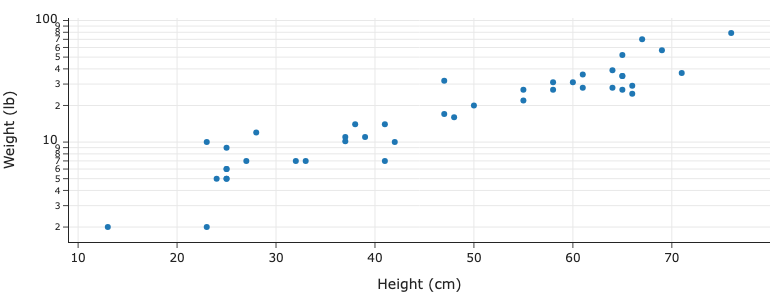

In [15]:
px.scatter(dogs, x='height', y='weight', log_y=True,
           labels={"height": "Height (cm)", "weight": "Weight (lb)"},
           width=300, height=300)

This plot shows a roughly linear relationship, and in this case, we say that there's a log–linear relationship between dog weight and height.

In general, when we see a linear relationship after transforming one or both axes, we can use
{numref}`Table %s <tab:transform-rels>` to reveal what relationship the original variables have (in the table, a and b are constants).
We make these transformations because it is easier for us to see if points fall along a line than to see if they follow a power law compared to an exponential.  

:::{table} Relationships between two variables when transformations are applied
:name: tab:transform-rels


| x-axis         | y-axis         | Relationship                | Also known as 
| :------------- | :------------- | :-------------------------- |:-------- 
| No transform   | No transform   | Linear: $ y = ax + b $      | Linear     
| Log–scale      | No transform   | Log: $ y = a \log x + b $   | Linear–log 
| No transform   | Log–scale      | Exponential: $ y = ba^x $   | Log–linear 
| Log–scale      | Log–scale      | Power: $ y = bx^a $         | Log–log    


:::

As {numref}`Table %s <tab:transform-rels>` shows, 
the log transform can reveal several common types of relationships.
Because of this, the log transform is considered the jackknife of 
transformations.
As another, albeit
artificial, example, the leftmost plot in
{numref}`Figure %s <example-transforms>`
reveals a curvilinear
relationship between _x_ and _y_. The middle plot shows a different curvilinear
relationship between _log(y)_ and _x_; this plot also appears nonlinear. A
further log transformation, at the far right, displays a plot of
_log(y)_ against _log(x)_. This plot confirms that the data have a log–log (or power)
relationship because the transformed points fall along a line.

```{figure} figures/example-transforms.png
---
name: example-transforms
---

Scatterplots showing how log transforms can "straighten" a curvilinear
relationship between two variables
```

Adjusting scale is an important practice in data visualization. While the log transform is versatile, it doesn't handle all situations where skew or curvature occurs. For example, at times the values are all roughly the same order of magnitude and the log transformation has little impact. Another transformation to consider is the square root transformation, which is often useful for count data. 

In the next section, we look at principles of smoothing, which we use 
when we need to visualize lots of data.